In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from pylib.analyze_agnostic import assay_agnostic_naive
from pylib.analyze_epistasis import (
    describe_skeletons,
    skeletonize_naive,
)
from pylib.modelsys_explicit import GenomeExplicit
from pylib.modelsys_explicit import (
    GenomeExplicit,
    CalcKnockoutEffectsAdditive,
    CalcKnockoutEffectsEpistasis,
    create_additive_array,
    create_epistasis_matrix_disjoint,
    describe_additive_array,
    describe_epistasis_matrix,
)


In [2]:
np.random.seed(1234)


## Create Sample Genome


In [3]:
num_sites = 10000
distn = lambda x: np.random.rand(x) * 0.7
additive_array = create_additive_array(num_sites, 0.04, distn)
epistasis_matrix = create_epistasis_matrix_disjoint(num_sites, 40, 4)
genome = GenomeExplicit(
    [
        CalcKnockoutEffectsAdditive(additive_array),
        CalcKnockoutEffectsEpistasis(epistasis_matrix, effect_size=(0.7, 1.6)),
    ],
)


## Describe and Inspect Genome


In [4]:
dfa = describe_additive_array(additive_array)
dfb = describe_epistasis_matrix(epistasis_matrix)
df_genome = pd.DataFrame.merge(dfa, dfb, on="site")
df_genome["site type"] = (
    df_genome["additive site"].astype(int)
    + df_genome["epistasis site"].astype(int) * 2
).map(
    {
        0: "neutral",
        1: "additive",
        2: "epistasis",
        3: "both",
    }
)

df_genome


,site,additive site,additive effect,epistasis site,num epistasis effects,site type
0,0,False,0.000000,False,0,neutral
1,1,True,0.049487,False,0,additive
2,2,True,0.396627,False,0,additive
3,3,False,0.000000,False,0,neutral
4,4,False,0.000000,False,0,neutral
...,...,...,...,...,...,...
9995,9995,False,0.000000,False,0,neutral
9996,9996,False,0.000000,False,0,neutral
9997,9997,False,0.000000,False,0,neutral
9998,9998,False,0.000000,False,0,neutral


How many of each kind of site are in the genome?


neutral      9445
additive      395
epistasis     155
both            5
Name: site type, dtype: int64
non-neutral 555


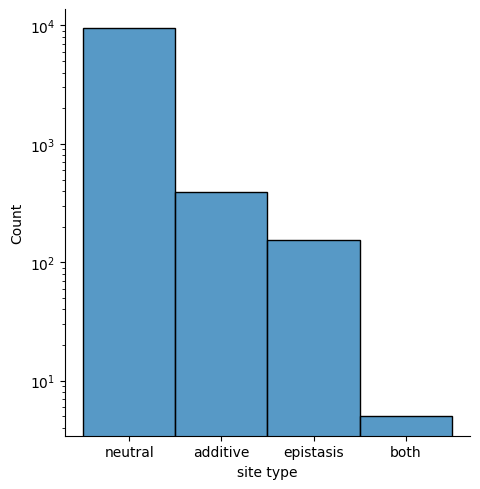

In [5]:
sns.displot(df_genome["site type"])
plt.yscale("log")
print(df_genome["site type"].value_counts())
print("non-neutral", (df_genome["site type"] != "neutral").sum())


## Perform Skeletonizations


In [6]:
num_skeletonizations = 5
skeletons = np.vstack(
    [
        skeletonize_naive(num_sites, genome.test_knockout)
        for _ in tqdm(range(num_skeletonizations))
    ],
)


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


Example skeleton.


array([False,  True,  True, ..., False, False, False])

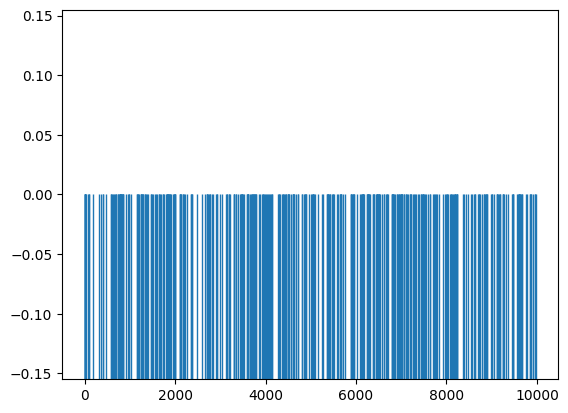

In [7]:
# convert from knockout true to retained true
retained_sites = ~skeletons[0].astype(bool)
sns.rugplot(
    np.flatnonzero(retained_sites),
    height=0.5,
)
retained_sites


## Describe Skeletons


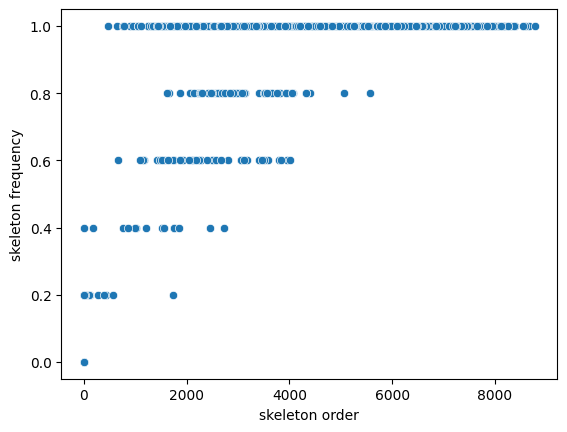

,site,"skeleton dose, excluded","skeleton dose std, excluded","skeleton dose ptp, excluded","skeleton exclusion order, excluded","skeleton exclusion order std, excluded","skeleton exclusion order ptp, excluded","skeleton outcome count, excluded","skeleton outcome frequency, excluded","skeleton dose, included",...,"skeleton outcome frequency, included",jackknife dose,jackknife dose std,jackknife dose ptp,raw jackknife result,raw jackknife result std,raw jackknife result ptp,jackknife result,jackknife result std,jackknife result ptp
0,0,9572.4,1.949359,5.0,6112.8,2598.985321,6445.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,9572.4,1.949359,5.0,1673.2,743.405475,1939.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,9572.4,1.949359,5.0,4427.4,2198.958003,5792.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,9572.4,1.949359,5.0,3214.2,2742.844363,7034.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,9572.4,1.949359,5.0,2921.8,2996.103920,7083.0,5,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9877,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.610976,0.000956,0.002268,1.610976,0.000956,0.002268
9996,9903,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.544390,0.000956,0.002268,1.544390,0.000956,0.002268
9997,9958,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.307906,0.000956,0.002268,1.307906,0.000956,0.002268
9998,9962,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,9572.4,...,1.0,9573.4,1.949359,5.0,1.689130,0.000956,0.002268,1.689130,0.000956,0.002268


In [8]:
sns.scatterplot(
    {
        "skeleton order": np.mean(skeletons, axis=0),
        "skeleton frequency": np.mean(skeletons.astype(bool), axis=0),
    },
    x="skeleton order",
    y="skeleton frequency",
)
plt.show()

df_skeletons = describe_skeletons(skeletons, genome.test_knockout)

df_skeletons


How many unique sites are in any skeleton?


In [9]:
np.any(
    (~skeletons.astype(bool)),
    axis=0,
).sum()


504

## Estimate Number Functional Sites

Using mark-recapture method.


In [10]:
assay_agnostic_naive(df_skeletons)


{'num sites estimate': 558.3499999999999,
 'num sites 95% CI': (533.2059805122569, 583.4940194877429)}